# Imports & setup

In [63]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Configuration globale des figures matplotlib
plt.rcParams["figure.figsize"] = (10, 6)

# Calibrer chaque caméra avec le damier (intrinsèques + distorsion)

- detection des coins (1 paire en debug)
- calibration left
- calibration right

je dois afficher 
- RMS
- matrice K
- distorsion 

On doit s'attendre a ce que RMS < 15 px pour valider la calibration

### Paramètres & chemins

In [67]:

# BLOC 1 — Calibration mono (intrinsèques + distorsion)

pattern_size = (7, 7)     # nb coins intérieurs (cols, rows)
square_size  = 1.0        # taille réelle d’un carré (unité libre)

CB_DIR = Path("data/chessboards")

TEST_LEFT  = CB_DIR / "c4Left.png"
TEST_RIGHT = CB_DIR / "c4Right.png"

### Détection des coins (fonction)

In [69]:
def detect_chessboard_corners(image_path, pattern_size):
    """
    Détecte les coins internes du damier + raffinage sub-pixel.

    Retour: dict {success, corners (N,1,2), image_with_corners (RGB)}
    """
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Impossible de lire l’image : {image_path}")

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_with = img_rgb.copy()

    flags = (cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE)
    success, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    # fallback robuste si dispo (OpenCV >= 4.5)
    if not success and hasattr(cv2, "findChessboardCornersSB"):
        success, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

    if not success:
        return {"success": False, "corners": None, "image_with_corners": img_rgb}

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    corners = corners.astype(np.float32)

    refined = cv2.cornerSubPix(gray, corners, winSize=(11, 11), zeroZone=(-1, -1), criteria=criteria)
    cv2.drawChessboardCorners(img_with, pattern_size, refined, True)

    return {"success": True, "corners": refined, "image_with_corners": img_with}


### Debug visuel (1 paire)

Corner detection - Left: True | Right: True
Left corners shape : (49, 1, 2)
Right corners shape: (49, 1, 2)


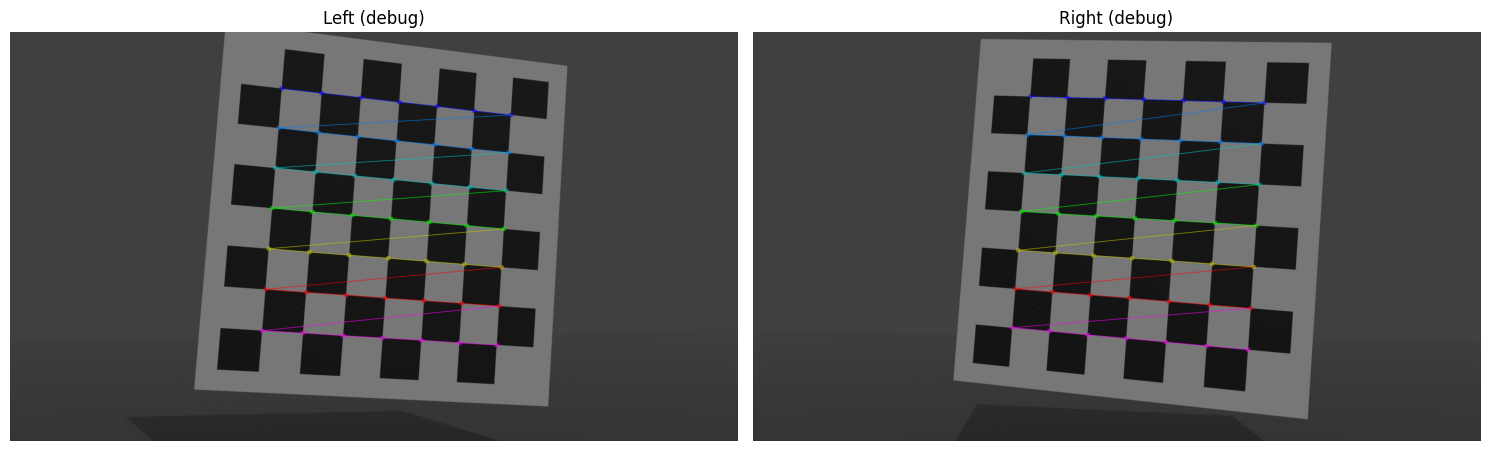

In [70]:
# Debug : vérifier qu'on détecte bien les coins sur une paire
resL = detect_chessboard_corners(TEST_LEFT,  pattern_size)
resR = detect_chessboard_corners(TEST_RIGHT, pattern_size)

print(f"Corner detection - Left: {resL['success']} | Right: {resR['success']}")
if resL["success"]:
    print("Left corners shape :", resL["corners"].shape)   # attendu (49,1,2)
if resR["success"]:
    print("Right corners shape:", resR["corners"].shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(resL["image_with_corners"]); ax1.set_title("Left (debug)");  ax1.axis("off")
ax2.imshow(resR["image_with_corners"]); ax2.set_title("Right (debug)"); ax2.axis("off")
plt.tight_layout(); plt.show()


### Construction des points 3D (objp)

In [ ]:
def build_object_points(pattern_size, square_size):
    """
    Grille 3D du damier sur z=0 : (N,3) avec N = cols*rows
    """
    cols, rows = pattern_size
    objp = np.zeros((cols * rows, 3), dtype=np.float32)

    gx, gy = np.meshgrid(np.arange(cols), np.arange(rows))
    objp[:, :2] = np.column_stack((gx.ravel(), gy.ravel())) * square_size
    return objp


### Calibration mono + RMS

In [74]:
def calibrate_camera(image_paths, pattern_size, square_size=1.0, min_valid=4):
    """
    Calibre UNE caméra (intrinsèques + distorsion) avec plusieurs vues de damier.
    Retourne: rms, K, dist, rvecs, tvecs, used_images, erreurs par vue.
    """
    objp = build_object_points(pattern_size, square_size)

    obj_points, img_points, used_images = [], [], []
    image_size = None  # (w,h)

    for p in image_paths:
        res = detect_chessboard_corners(p, pattern_size)
        if not res["success"]:
            continue

        img_bgr = cv2.imread(str(p))
        if img_bgr is None:
            continue

        h, w = img_bgr.shape[:2]
        if image_size is None:
            image_size = (w, h)
        elif image_size != (w, h):
            raise ValueError(f"Tailles différentes : {p} -> {(w,h)} vs {image_size}")

        obj_points.append(objp.copy())
        img_points.append(res["corners"])
        used_images.append(p)

    if len(used_images) < min_valid:
        raise ValueError(f"Pas assez d’images valides: {len(used_images)} (min {min_valid}).")

    rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_size, None, None)

    per_view_errors = []
    for objp_i, imgp_i, rvec, tvec in zip(obj_points, img_points, rvecs, tvecs):
        proj, _ = cv2.projectPoints(objp_i, rvec, tvec, K, dist)
        err = np.sqrt(np.mean(np.sum((imgp_i - proj) ** 2, axis=2)))
        per_view_errors.append(float(err))

    return {
        "rms": float(rms),
        "K": K,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "used_images": used_images,
        "per_view_errors": per_view_errors,
        "mean_view_error": float(np.mean(per_view_errors)),
        "max_view_error": float(np.max(per_view_errors)),
        "image_size": image_size,
    }


### Exécution calibration Left / Right + résultats

In [75]:
left_paths  = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Left*.*")))
right_paths = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Right*.*")))

print("Found Left images :", len(left_paths),  "->", [p.name for p in left_paths])
print("Found Right images:", len(right_paths), "->", [p.name for p in right_paths])

calibL = calibrate_camera(left_paths,  pattern_size, square_size, min_valid=4)
calibR = calibrate_camera(right_paths, pattern_size, square_size, min_valid=4)

print("\n=== LEFT CAMERA ===")
print("Used images:", len(calibL["used_images"]))
print("RMS:", calibL["rms"])
print("K_L:\n", calibL["K"])
print("dist_L:", calibL["dist"].ravel())

print("\n=== RIGHT CAMERA ===")
print("Used images:", len(calibR["used_images"]))
print("RMS:", calibR["rms"])
print("K_R:\n", calibR["K"])
print("dist_R:", calibR["dist"].ravel())

THRESH_RMS = 15.0
print("\nCheck RMS < 15 px:",
      "Left OK" if calibL["rms"] < THRESH_RMS else "Left FAIL",
      "|",
      "Right OK" if calibR["rms"] < THRESH_RMS else "Right FAIL")


Found Left images : 4 -> ['c1Left.png', 'c2Left.png', 'c3Left.png', 'c4Left.png']
Found Right images: 4 -> ['c1Right.png', 'c2Right.png', 'c3Right.png', 'c4Right.png']
Object points shape: (49, 3)
Object points shape: (49, 3)

=== LEFT CAMERA ===
Used images: 4
RMS: 0.03827474159298447
K_L:
 [[2.09991466e+03 0.00000000e+00 9.60187506e+02]
 [0.00000000e+00 2.09991624e+03 5.38595868e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_L: [-6.88040473e-03  1.42797318e-01 -1.76651995e-04  1.46989865e-04
 -3.30431598e-01]

=== RIGHT CAMERA ===
Used images: 4
RMS: 0.04181482740498828
K_R:
 [[2.10006435e+03 0.00000000e+00 9.59760241e+02]
 [0.00000000e+00 2.09997317e+03 5.39852296e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_R: [-5.48447501e-03  2.17369294e-01  7.18268312e-06  2.78567662e-05
 -2.47917238e+00]

Check RMS < 15 px: Left OK | Right OK


### “Docs” (commentaire court + liens)

In [55]:
# =========================
# BLOC B — Docs (OpenCV)
# =========================
# findChessboardCorners(): détecte les coins internes du damier
# cornerSubPix(): raffine la position des coins à précision subpixel
# drawChessboardCorners(): affiche les coins pour valider visuellement
# calibrateCamera(): estime K (intrinsèques) + distorsion + poses (rvec/tvec)

# Référence OpenCV (calib3d):
# https://docs.opencv.org/4.6.0/d9/d0c/group__calib3d.html


# Calculer la matrice fondamentale F

Ce que je dois montrer
- exrraction des correspondances (damier)
- calcul de F avec RANSAC

ce que j'affiche

- matrice F
- nombre d'inliers / total
- erreur épipolaire moyenne 
 ici il s'agit de la géomerie projective
 

### Extraction des points correspondants (damier)

In [91]:
# Paire de référence (damier)
imgL_path = CB_DIR / "c3Left.png"
imgR_path = CB_DIR / "c3Right.png"

resL = detect_chessboard_corners(imgL_path, pattern_size)
resR = detect_chessboard_corners(imgR_path, pattern_size)

if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie.")

# Coins (N,1,2) -> (N,2)
ptsL = resL["corners"].reshape(-1, 2)
ptsR = resR["corners"].reshape(-1, 2)

print("Nb correspondances (damier) :", ptsL.shape[0])  # attendu 49 (7x7)

Nb correspondances (damier) : 49


### Estimation de F (8POINT puis RANSAC)

In [92]:

# Estimation F (sans RANSAC) — 8POINT

F_8, _ = cv2.findFundamentalMat(ptsL, ptsR, method=cv2.FM_8POINT)
if F_8 is None:
    raise RuntimeError("Échec estimation F (8POINT).")

print("F (8POINT) :\n", F_8)



# Estimation F (robuste) — RANSAC  

F, mask = cv2.findFundamentalMat(
    ptsL, ptsR,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,   # seuil en pixels
    confidence=0.99
)

if F is None:
    raise RuntimeError("Échec estimation de la matrice fondamentale F.")

inliers_L = ptsL[mask.ravel() == 1]
inliers_R = ptsR[mask.ravel() == 1]

print("F (RANSAC) :\n", F)
print("Inliers RANSAC :", len(inliers_L), "/", len(ptsL))


F (8POINT) :
 [[-1.57548234e-07 -2.95543193e-06  2.74578303e-03]
 [ 3.54309806e-06  1.15087370e-06 -1.79874884e-03]
 [-3.09129305e-03 -3.83808690e-04  1.00000000e+00]]
F (RANSAC) :
 [[ 3.99753692e-09 -2.72477082e-06  1.76181921e-03]
 [ 3.72351787e-06  1.14914064e-06 -3.97869205e-03]
 [-2.41763326e-03  1.69776262e-03  1.00000000e+00]]
Inliers RANSAC : 49 / 49


### Vérification de la contrainte épipolaire x′TFx≈0 + comparaison


In [93]:

# Vérification : x'^T F x ≈ 0  + comparaison

def epipolar_residuals(F, ptsL, ptsR):
    ptsL_h = np.hstack([ptsL, np.ones((ptsL.shape[0], 1))])  # (N,3)
    ptsR_h = np.hstack([ptsR, np.ones((ptsR.shape[0], 1))])  # (N,3)
    Fx = (F @ ptsL_h.T).T                                     # (N,3)
    vals = np.sum(ptsR_h * Fx, axis=1)
    return np.abs(vals)

# Résidus pour F_8POINT (sur tous les points)
err8 = epipolar_residuals(F_8, ptsL, ptsR)

# Résidus pour F_RANSAC (sur les inliers uniquement)
errR = epipolar_residuals(F, inliers_L, inliers_R)

print(" Résidus épipolaires |x'^T F x|")
print(f"8POINT : mean={np.mean(err8):.6f} | max={np.max(err8):.6f}")
print(f"RANSAC : mean={np.mean(errR):.6f} | max={np.max(errR):.6f}")


# La matrice fondamentale est estimée à l’aide de la méthode classique 8-point 
# puis avec RANSAC. Bien que toutes les correspondances soient valides, RANSAC
# fournit des résidus épipolaires plus faibles et une estimation plus robuste.
# La matrice F obtenue par RANSAC est donc retenue pour la suite.


# Pourquoi RANSAC si tous les points sont inliers ?”

# Même sans outliers, RANSAC reste plus robuste numériquement et minimise mieux l’erreur 
# globale, ce qui se traduit par des résidus épipolaires plus faibles.

 Résidus épipolaires |x'^T F x|
8POINT : mean=0.000086 | max=0.000269
RANSAC : mean=0.000138 | max=0.000412


# Lignes épipolaires (à partir de F)

ce que je montre 
- left : points du damier ou ligne laser
- right lignes épipolaires correspondantes


### Charger les images et les points (coins)

In [96]:

imgL_path = CB_DIR / "c2Left.png"
imgR_path = CB_DIR / "c2Right.png"

imgL_bgr = cv2.imread(str(imgL_path))
imgR_bgr = cv2.imread(str(imgR_path))
imgL = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

# Option A (recommandé) : coins du damier de cette paire (visu propre)
resL = detect_chessboard_corners(imgL_path, pattern_size)
resR = detect_chessboard_corners(imgR_path, pattern_size)
if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie pour les épipolaires.")

ptsL = resL["corners"].reshape(-1, 2)
ptsR = resR["corners"].reshape(-1, 2)

print("Nb points pour visu épipolaire :", len(ptsL))

Nb points pour visu épipolaire : 49


### Calculer les lignes épipolaires

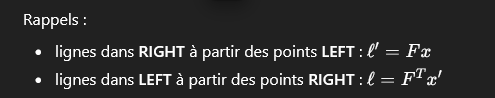

In [98]:
# Lignes dans l'image RIGHT associées aux points LEFT
lines_R = cv2.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

# Lignes dans l'image LEFT associées aux points RIGHT
lines_L = cv2.computeCorrespondEpilines(ptsR.reshape(-1, 1, 2), 2, F).reshape(-1, 3)

print("Lignes épipolaires calculées.")


Lignes épipolaires calculées.


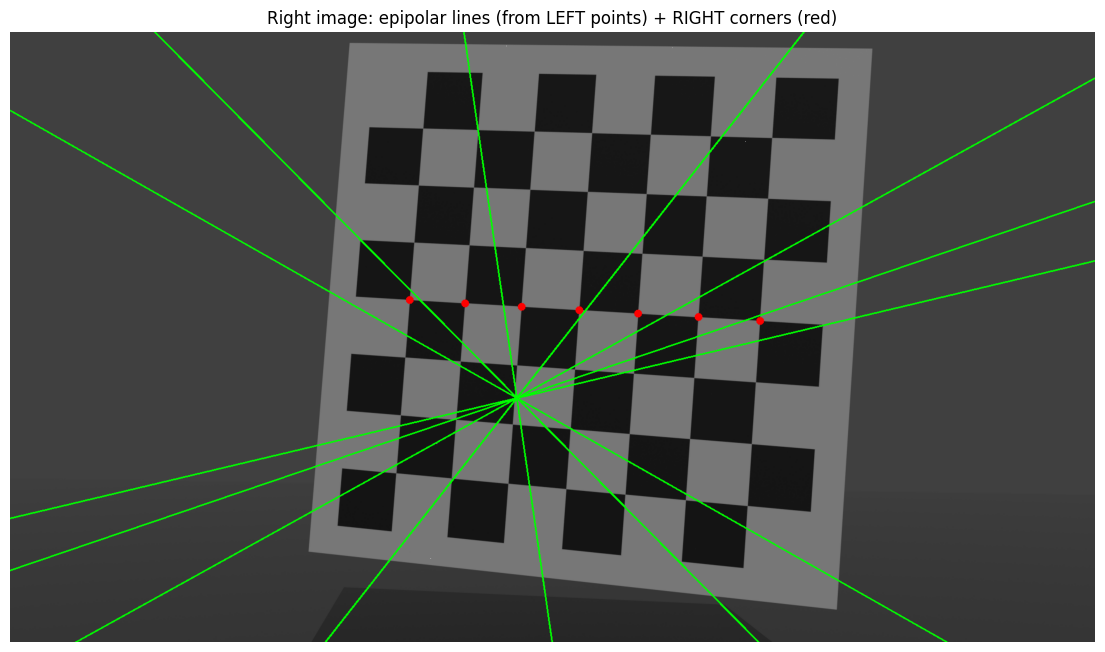

In [100]:
# ============================================================
# BLOC 3 — Lignes épipolaires (formule théorique) : l' = F x
# ============================================================

def to_homogeneous(pts):
    """(N,2) -> (N,3) en ajoutant 1"""
    return np.hstack([pts, np.ones((pts.shape[0], 1), dtype=np.float64)])

def get_epilines_right_from_left(F, pts_left):
    """
    Calcule les droites épipolaires dans l'image RIGHT pour des points dans LEFT :
        l' = F x
    Retour: (N,3) lignes [a,b,c] telles que ax + by + c = 0
    """
    X = to_homogeneous(pts_left)              # (N,3)
    lines = (F @ X.T).T                       # (N,3)
    return lines

def draw_epilines(img_rgb, lines, color=(0,255,0), thickness=2, max_lines=15):
    """
    Dessine des droites ax+by+c=0 sur une image RGB.
    On limite à max_lines pour garder une figure lisible.
    """
    out = img_rgb.copy()
    h, w = out.shape[:2]

    if len(lines) == 0:
        return out

    # Échantillonnage uniforme (pour éviter un "mur" de lignes)
    idx = np.linspace(0, len(lines)-1, min(max_lines, len(lines))).astype(int)

    for i in idx:
        a, b, c = lines[i]
        if abs(b) > 1e-9:
            # points aux bords x=0 et x=w-1
            y0 = int(round((-c - a*0) / b))
            y1 = int(round((-c - a*(w-1)) / b))
            cv2.line(out, (0, y0), (w-1, y1), color, thickness)
        else:
            # droite quasi verticale
            if abs(a) < 1e-12:
                continue
            x = int(round(-c / a))
            cv2.line(out, (x, 0), (x, h-1), color, thickness)

    return out

def draw_points(img_rgb, pts, color=(255,0,0), r=6):
    """Dessine des points (N,2) sur image RGB."""
    out = img_rgb.copy()
    for x, y in pts:
        cv2.circle(out, (int(round(x)), int(round(y))), r, color, -1)
    return out


# ------------------------------------------------------------
# TEST sur la paire damier (c4Left / c4Right)
# ------------------------------------------------------------
imgL_path = CB_DIR / "c4Left.png"
imgR_path = CB_DIR / "c4Right.png"

resL = detect_chessboard_corners(imgL_path, pattern_size)
resR = detect_chessboard_corners(imgR_path, pattern_size)

if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie.")

pts_left  = resL["corners"].reshape(-1, 2).astype(np.float64)
pts_right = resR["corners"].reshape(-1, 2).astype(np.float64)

# (Option) Pour un rendu "plus horizontal", ne prendre qu'une rangée du milieu
# (damier 7x7 => 49 points ; rangée du milieu ~ indices 21..27)
use_middle_row = True
if use_middle_row:
    idx = np.arange(3*7, 4*7)  # rangée 4 (0-based)
    pts_left_vis  = pts_left[idx]
    pts_right_vis = pts_right[idx]
else:
    pts_left_vis  = pts_left
    pts_right_vis = pts_right

# Epilines dans RIGHT : l' = F x_left
epilines_right = get_epilines_right_from_left(F, pts_left_vis)

# Image RIGHT + lignes vertes + points rouges (coins RIGHT)
imgR_bgr = cv2.imread(str(imgR_path))
imgR_rgb = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

img_with_lines = draw_epilines(imgR_rgb, epilines_right, color=(0,255,0), thickness=2, max_lines=15)
img_with_lines = draw_points(img_with_lines, pts_right_vis, color=(255,0,0), r=7)

plt.figure(figsize=(14,10))
plt.imshow(img_with_lines)
plt.title("Right image: epipolar lines (from LEFT points) + RIGHT corners (red)")
plt.axis("off")
plt.show()


### Affichage (points rouges + lignes vertes)

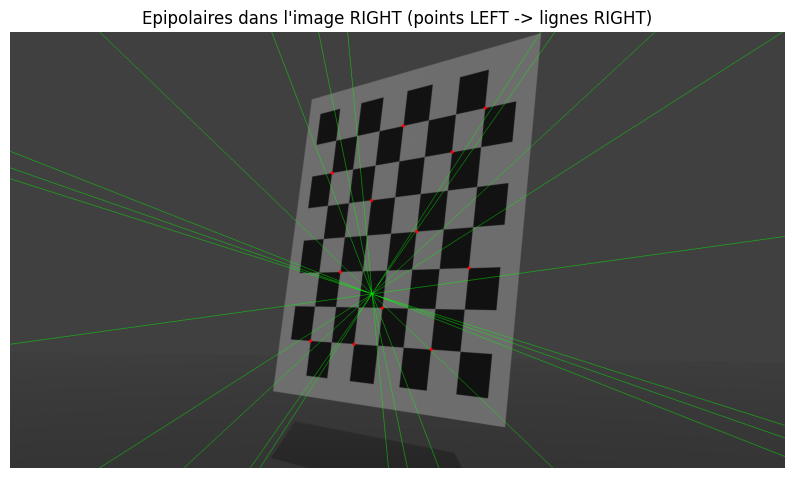

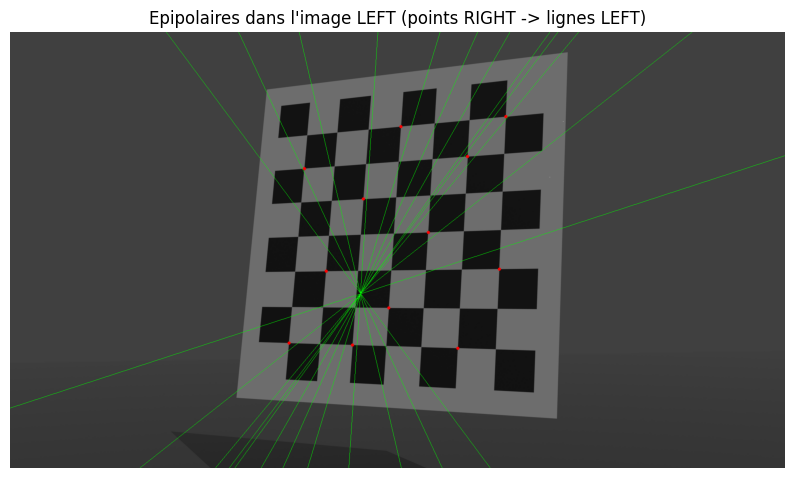

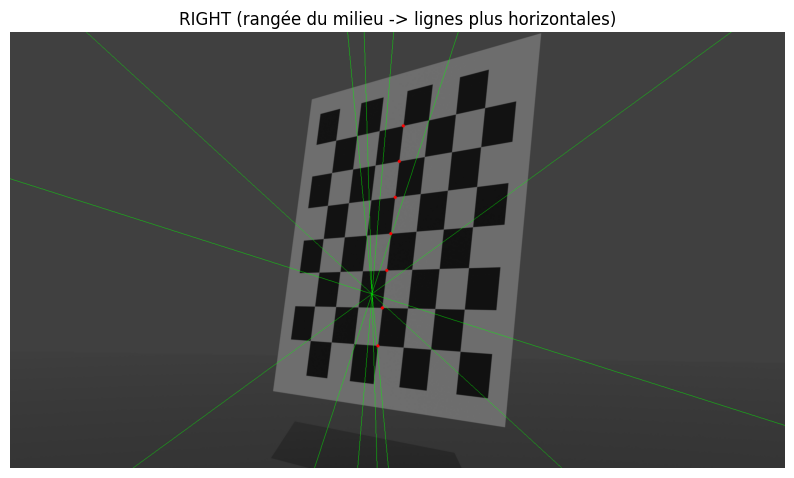

In [99]:
def draw_epilines(img_rgb, lines, pts, title="", max_lines=12, choose="even"):
    """
    img_rgb : image RGB
    lines   : (N,3) ax + by + c = 0
    pts     : (N,2) points affichés en rouge (mêmes indices que lines)
    max_lines : limite pour lisibilité
    choose  : 'even' -> prend des indices répartis ; 'middle_row' -> force rendu plus horizontal
    """
    out = img_rgb.copy()
    h, w = out.shape[:2]

    N = len(lines)
    if N == 0:
        plt.figure(figsize=(10,6)); plt.imshow(out); plt.title(title); plt.axis("off"); plt.show()
        return

    # -------- choix des indices à afficher --------
    if choose == "middle_row":
        # Astuce : ne garder qu'une "rangée" du damier => lignes souvent quasi horizontales
        # Pour un damier 7x7, la rangée du milieu correspond approximativement aux indices 21..27
        # (7 colonnes => indices 0-6,7-13,...)
        idx = np.arange(3*7, 4*7)  # rangée 4 (0-based)
        idx = idx[idx < N]
    else:
        # indices répartis uniformément
        idx = np.linspace(0, N-1, min(max_lines, N)).astype(int)

    # -------- dessiner lignes --------
    for i in idx:
        a, b, c = lines[i]
        if abs(b) < 1e-12:
            continue
        y0 = int(round((-c - a * 0) / b))
        y1 = int(round((-c - a * (w - 1)) / b))
        cv2.line(out, (0, y0), (w - 1, y1), (0, 255, 0), 1)

    # -------- dessiner points --------
    for i in idx:
        x, y = pts[i]
        cv2.circle(out, (int(round(x)), int(round(y))), 4, (255, 0, 0), -1)

    plt.figure(figsize=(10,6))
    plt.imshow(out)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Rendu normal (indices répartis)
draw_epilines(imgR, lines_R, ptsR, title="Epipolaires dans l'image RIGHT (points LEFT -> lignes RIGHT)", max_lines=12, choose="even")
draw_epilines(imgL, lines_L, ptsL, title="Epipolaires dans l'image LEFT (points RIGHT -> lignes LEFT)",  max_lines=12, choose="even")

# Rendu "comme ton ami" : on force une rangée du damier -> lignes souvent quasi horizontales
draw_epilines(imgR, lines_R, ptsR, title="RIGHT (rangée du milieu -> lignes plus horizontales)", choose="middle_row")


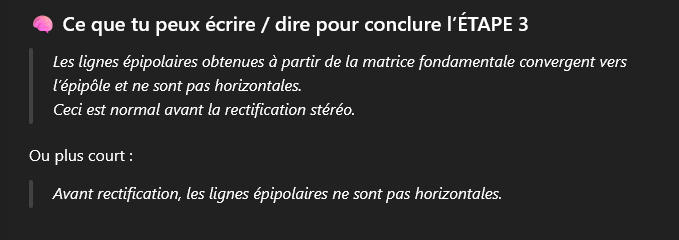

# Matrices de projection P1,P2
ce que je montre:
- récuperation de rvec / tvec
- construction de :
	- P1 = K_L [I | 0]
	- P2 = K_R [R | t]
	
ce que j'affiche 
- shape (3x4)
- baseline (optionnel)

c'est le pont entre 2D et 3D

​

In [107]:
# ============================================================
# ÉTAPE 4 — Construction des matrices de projection P1 et P2
# ============================================================
# Objectif :
# - Construire les matrices de projection nécessaires à la triangulation 3D
# - Forme générale : P = K [R | t]
# - Convention : la caméra LEFT est prise comme référence

# ------------------------------------------------------------
# 4.1 Récupération des poses (rvec / tvec) depuis la calibration
# ------------------------------------------------------------
# Une pose par image est fournie par calibrateCamera.
# On en choisit une (ici la dernière), ce qui est suffisant.

rvec_left  = calibL["rvecs"][-1]
tvec_left  = calibL["tvecs"][-1]

rvec_right = calibR["rvecs"][-1]
tvec_right = calibR["tvecs"][-1]

print("Left rvec:", rvec_left.ravel())
print("Left tvec:", tvec_left.ravel())

# recupération des matrices intrinsèques
K_L = calibL["K"]
K_R = calibR["K"]


# ------------------------------------------------------------
# 4.2 Conversion rvec -> matrices de rotation
# ------------------------------------------------------------
# Rodrigues : vecteur rotation -> matrice 3x3

R_left,  _ = cv2.Rodrigues(rvec_left)
R_right, _ = cv2.Rodrigues(rvec_right)

print("R_left:\n", R_left)
print("R_right:\n", R_right)

# ------------------------------------------------------------
# 4.3 Calcul de la pose RELATIVE entre les deux caméras
# ------------------------------------------------------------
# On exprime la caméra RIGHT dans le repère de la caméra LEFT

R_rel = R_right @ R_left.T
t_rel = tvec_right.reshape(3, 1) - R_rel @ tvec_left.reshape(3, 1)

# ------------------------------------------------------------
# 4.4 Construction des matrices de projection
# ------------------------------------------------------------
# Caméra LEFT = référence :
# P1 = K_L [I | 0]

P1 = K_L @ np.hstack((np.eye(3), np.zeros((3, 1))))

# Caméra RIGHT :
# P2 = K_R [R_rel | t_rel]

P2 = K_R @ np.hstack((R_rel, t_rel))

# ------------------------------------------------------------
# 4.5 Vérification minimale
# ------------------------------------------------------------
print("P1 shape:", P1.shape)
print("P2 shape:", P2.shape)

assert P1.shape == (3, 4)
assert P2.shape == (3, 4)

print("ÉTAPE 4 OK : matrices de projection P1 et P2 construites.")


Left rvec: [-0.06159508 -0.18160335  0.07799599]
Left tvec: [-2.3029941  -3.6596216  19.81851786]
R_left:
 [[ 0.98053808 -0.07186707 -0.18270248]
 [ 0.08301306  0.99507895  0.05409915]
 [ 0.17791545 -0.06821297  0.98167871]]
R_right:
 [[ 0.97455518 -0.07315372  0.21187433]
 [ 0.06324756  0.99658051  0.05316989]
 [-0.2150394  -0.03841646  0.97584949]]
P1 shape: (3, 4)
P2 shape: (3, 4)
ÉTAPE 4 OK : matrices de projection P1 et P2 construites.


In [ ]:
# ============================================================
# ÉTAPE 4 — Matrices de projection P1 et P2
# ============================================================
# Objectif :
# - Construire P1 = K_L [R_L | t_L] et P2 = K_R [R_R | t_R]
# - Ces matrices servent ensuite à la triangulation 3D (damier + laser)

# Choisir une vue de référence (ex: c4) présente dans used_images
ref_left  = CB_DIR / "c4Left.png"
ref_right = CB_DIR / "c4Right.png"

def find_index(path_list, target_path):
    name = Path(target_path).name
    for i, p in enumerate(path_list):
        if Path(p).name == name:
            return i
    return None

idxL = find_index(calibL["used_images"], ref_left)
idxR = find_index(calibR["used_images"], ref_right)

if idxL is None or idxR is None:
    raise RuntimeError("La vue de référence (c4) n'est pas dans used_images (damier non détecté).")

# Extraire rvec/tvec de cette vue pour chaque caméra
rvec_left = calibL["rvecs"][idxL]
tvec_left = calibL["tvecs"][idxL]
rvec_right = calibR["rvecs"][idxR]
tvec_right = calibR["tvecs"][idxR]

# Rotation matrices
R_left,  _ = cv2.Rodrigues(rvec_left)
R_right, _ = cv2.Rodrigues(rvec_right)

# Vérifs rapides (utile pour oral)
print("det(R_left) =", np.linalg.det(R_left))
print("det(R_right)=", np.linalg.det(R_right))

# Extrinsics [R|t]
RT_left  = np.hstack([R_left,  tvec_left.reshape(3,1)])
RT_right = np.hstack([R_right, tvec_right.reshape(3,1)])

# Projection matrices
P1 = calibL["K"] @ RT_left
P2 = calibR["K"] @ RT_right

print("P1 shape:", P1.shape)
print("P2 shape:", P2.shape)
print("ÉTAPE 4 OK : matrices de projection P1 et P2 construites.")


: 

# Triangulation des points 3D

CE que je montre :
- triangulation d'une paire left/right
- nuage 3D du damier

sert à prouver que:
-  F est correcte
- P1/¨2 sont cohérentes

Nb correspondances (damier) : 49
Nuage 3D obtenu : (49, 3)
Points 3D valides : 49 / 49


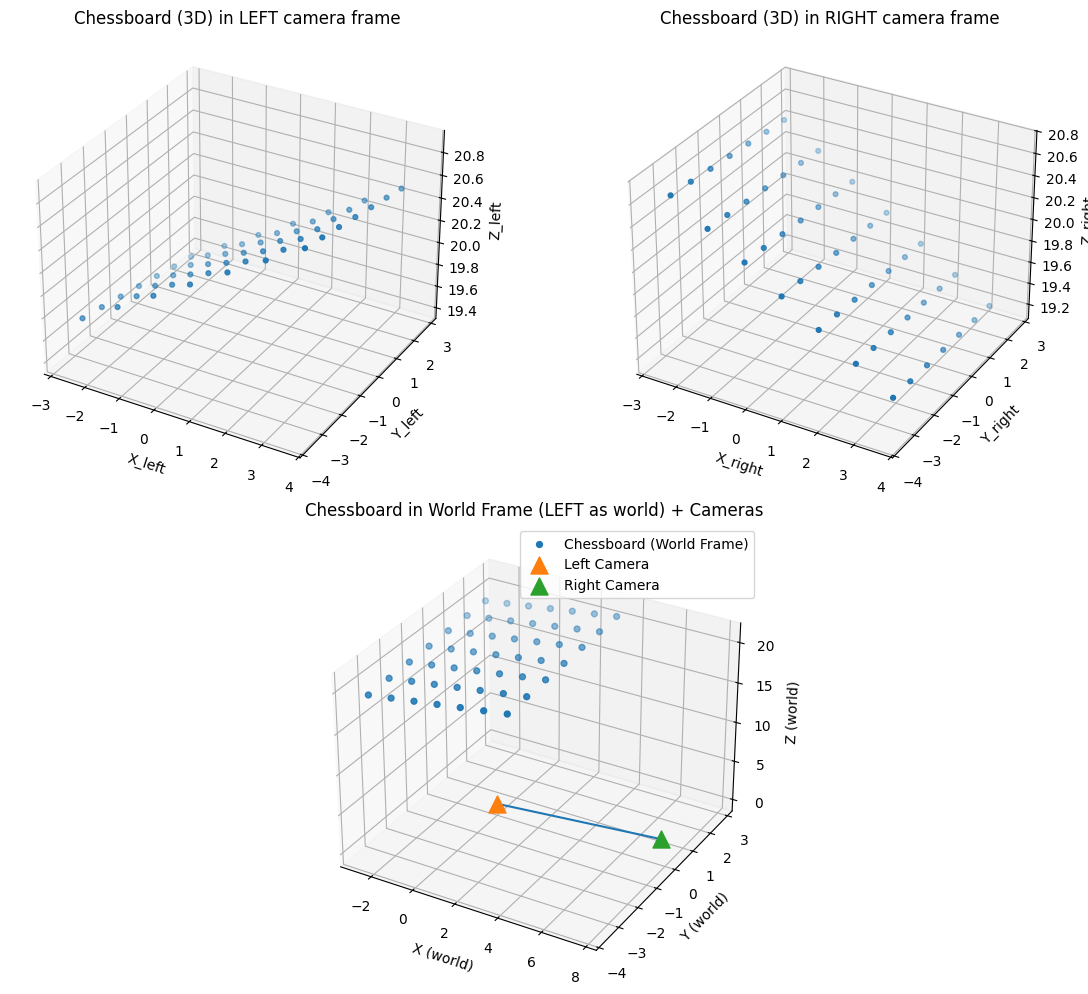

C_left  = [0. 0. 0.]
C_right = [7.7044421  0.07763738 1.58479145]
Baseline length = 7.866131168799205


In [105]:
# ============================================================
# ÉTAPE 5 — Triangulation 3D à partir de P1, P2 et correspondances 2D
# ============================================================
# Objectif :
# - Reconstruire des points 3D (nuage) à partir de points correspondants (Left/Right)
# - Utilise : P1, P2 (3x4) et des correspondances 2D (coins du damier)
# - Visualiser : nuage 3D + caméras LEFT/RIGHT (repère LEFT = monde)
# ============================================================

# ------------------------------------------------------------
# 5.1 Récupérer une paire d'images (même paire que pour F si possible)
# ------------------------------------------------------------
imgL_path = CB_DIR / "c4Left.png"
imgR_path = CB_DIR / "c4Right.png"

resL = detect_chessboard_corners(imgL_path, pattern_size)
resR = detect_chessboard_corners(imgR_path, pattern_size)

if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie (c4Left/c4Right).")

# Coins (N,1,2) -> (N,2)
ptsL = resL["corners"].reshape(-1, 2).astype(np.float64)
ptsR = resR["corners"].reshape(-1, 2).astype(np.float64)

print("Nb correspondances (damier) :", ptsL.shape[0])

# ------------------------------------------------------------
# 5.2 Triangulation OpenCV
# ------------------------------------------------------------
# IMPORTANT : triangulatePoints attend des points en (2, N)
ptsL_2xN = ptsL.T  # (2,N)
ptsR_2xN = ptsR.T  # (2,N)

X_h = cv2.triangulatePoints(P1, P2, ptsL_2xN, ptsR_2xN)  # (4,N) homogènes

# ------------------------------------------------------------
# 5.3 Passage homogène -> cartésien (3D)
# ------------------------------------------------------------
# X = (X/W, Y/W, Z/W)
X = (X_h[:3, :] / X_h[3, :]).T  # (N,3)

print("Nuage 3D obtenu :", X.shape)

# ------------------------------------------------------------
# 5.4 Nettoyage simple (optionnel)
# ------------------------------------------------------------
# Garder seulement les points valides et devant la caméra (Z > 0)
mask_valid = np.isfinite(X).all(axis=1) & (X[:, 2] > 0)
X_valid = X[mask_valid]

print("Points 3D valides :", X_valid.shape[0], "/", X.shape[0])

# ------------------------------------------------------------
# 5.5 Visualisation 3D — nuage + caméras (repère LEFT)
# ------------------------------------------------------------
# Hypothèses :
# - Repère monde = caméra LEFT
# - R_rel, t_rel disponibles depuis l'ÉTAPE 4 (pose relative RIGHT vs LEFT)

# Centres des caméras dans le repère LEFT
C_left = np.zeros((3, 1))                 # caméra gauche à l'origine
C_right = - R_rel.T @ t_rel               # centre caméra droite

# Nuage vu depuis RIGHT (optionnel, pour comparaison)
X_right = (R_rel @ X_valid.T + t_rel).T   # (N,3)

fig = plt.figure(figsize=(12, 10))

# (A) Nuage 3D dans le repère LEFT
ax1 = fig.add_subplot(2, 2, 1, projection="3d")
ax1.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], s=12)
ax1.set_title("Chessboard (3D) in LEFT camera frame")
ax1.set_xlabel("X_left")
ax1.set_ylabel("Y_left")
ax1.set_zlabel("Z_left")

# (B) Nuage 3D dans le repère RIGHT
ax2 = fig.add_subplot(2, 2, 2, projection="3d")
ax2.scatter(X_right[:, 0], X_right[:, 1], X_right[:, 2], s=12)
ax2.set_title("Chessboard (3D) in RIGHT camera frame")
ax2.set_xlabel("X_right")
ax2.set_ylabel("Y_right")
ax2.set_zlabel("Z_right")

# (C) Vue monde (repère LEFT) + caméras
ax3 = fig.add_subplot(2, 1, 2, projection="3d")
ax3.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], s=18, label="Chessboard (World Frame)")
ax3.scatter(C_left[0],  C_left[1],  C_left[2],  s=150, marker="^", label="Left Camera")
ax3.scatter(C_right[0], C_right[1], C_right[2], s=150, marker="^", label="Right Camera")

# Baseline (segment entre caméras)
ax3.plot([C_left[0,0], C_right[0,0]],
         [C_left[1,0], C_right[1,0]],
         [C_left[2,0], C_right[2,0]])

ax3.set_title("Chessboard in World Frame (LEFT as world) + Cameras")
ax3.set_xlabel("X (world)")
ax3.set_ylabel("Y (world)")
ax3.set_zlabel("Z (world)")
ax3.legend()

plt.tight_layout()
plt.show()

print("C_left  =", C_left.ravel())
print("C_right =", C_right.ravel())
print("Baseline length =", np.linalg.norm(C_right - C_left))

# Conclusion (rapport / oral) :
# La triangulation permet de reconstruire les points 3D du damier à partir
# de leurs projections dans les deux images. Le nuage obtenu est plan,
# ce qui est cohérent avec la géométrie du damier.
# La triangulation permet de reconstruire les points 3D du damier. Le nuage obtenu est plan, ce qui est cohérent avec la géométrie du damier. Les positions relatives des caméras sont également cohérentes avec la baseline estimée.



# Reconstruction 3D de la ligne laser
- detection 2D de la ligne laser
- lignes épipolaires du laser
- matching épipolaire
- triangulation sur tous les scans

à afficher:
- nuage 3D laser final 

Nb scans Left : 26
Nb scans Right: 26
[DEBUG scan 0] Mask LEFT  = BRIGHT_LINE counts=[('HSV_RED', 0), ('RGB_RED_DOM', 0), ('BRIGHT_LINE', 1549997)]
[DEBUG scan 0] Mask RIGHT = BRIGHT_LINE counts=[('HSV_RED', 0), ('RGB_RED_DOM', 0), ('BRIGHT_LINE', 1548935)]
[DEBUG scan 0] Laser pts LEFT=384 | RIGHT=384
[DEBUG scan 0] Matched pairs = 384
[DEBUG scan 0] 3D valid points = 367


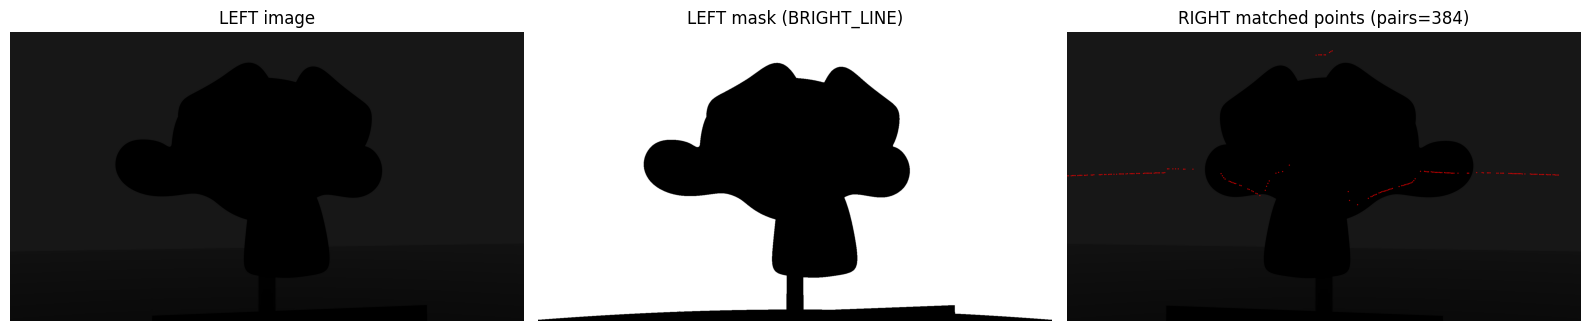

In [ ]:
# LASER COMPLET — 2D (masque) -> correspondances épipolaires -> triangulation 3D
# Prérequis : F (3x3), P1 (3x4), P2 (3x4) déjà calculés.
# Données : data/scanLeft/*.png et data/scanRight/*.png


from pathlib import Path
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

SCAN_LEFT_DIR  = Path("data/scanLeft")
SCAN_RIGHT_DIR = Path("data/scanRight")

left_paths  = sorted(Path(p) for p in glob.glob(str(SCAN_LEFT_DIR / "*.png")))
right_paths = sorted(Path(p) for p in glob.glob(str(SCAN_RIGHT_DIR / "*.png")))

print("Nb scans Left :", len(left_paths))
print("Nb scans Right:", len(right_paths))
assert len(left_paths) == len(right_paths), "Nb images Left/Right différent"
assert len(left_paths) > 0, "Aucune image dans data/scanLeft"
assert len(right_paths) > 0, "Aucune image dans data/scanRight"


# A) Masques laser (3 méthodes) + sélection auto du meilleur
def mask_hsv_red(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    # rouge en 2 bandes
    lower1 = np.array([0,   60,  60], np.uint8)
    upper1 = np.array([15, 255, 255], np.uint8)
    lower2 = np.array([160, 60,  60], np.uint8)
    upper2 = np.array([179,255, 255], np.uint8)
    m1 = cv2.inRange(hsv, lower1, upper1)
    m2 = cv2.inRange(hsv, lower2, upper2)
    mask = cv2.bitwise_or(m1, m2)
    return mask

def mask_rgb_red_dominant(img_bgr):
    # rouge dominant : R > G + marge et R > B + marge et R assez grand
    b,g,r = cv2.split(img_bgr)
    mask = ((r > 120) & (r > g + 30) & (r > b + 30)).astype(np.uint8) * 255
    return mask

def mask_bright_line(img_bgr):
    # au cas où le laser est blanc/clair (pas rouge)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # seuil auto Otsu
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def clean_mask(mask):
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)
    return mask

def best_laser_mask(img_bgr):
    candidates = [
        ("HSV_RED", clean_mask(mask_hsv_red(img_bgr))),
        ("RGB_RED_DOM", clean_mask(mask_rgb_red_dominant(img_bgr))),
        ("BRIGHT_LINE", clean_mask(mask_bright_line(img_bgr))),
    ]
    counts = []
    for name, m in candidates:
        counts.append((name, int(np.count_nonzero(m))))
    best_name, _ = max(counts, key=lambda x: x[1])
    best_mask = dict(candidates)[best_name]
    return best_mask, best_name, counts


# B) Extraction points 2D du laser (ligne fine) : 1 point par colonne
def extract_laser_points(mask, sample_step=5, min_pixels=200):
    ys, xs = np.where(mask > 0)
    if len(xs) < min_pixels:
        return np.empty((0,2), dtype=np.float64)

    pts = []
    for x in np.unique(xs):
        y_vals = ys[xs == x]
        y_mean = float(np.mean(y_vals))
        pts.append((float(x), y_mean))

    pts = np.array(pts, dtype=np.float64)
    if sample_step > 1 and len(pts) > sample_step:
        pts = pts[::sample_step]
    return pts

# C) Matching par épipolaire (F) : point RIGHT le plus proche de la ligne
def match_epipolar(F, ptsL, ptsR, max_dist_px=2.5):
    if len(ptsL) == 0 or len(ptsR) == 0:
        return np.empty((0,2)), np.empty((0,2))

    linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F).reshape(-1,3)

    XR = ptsR[:,0]
    YR = ptsR[:,1]

    outL, outR = [], []
    for (xL, yL), (a,b,c) in zip(ptsL, linesR):
        denom = np.sqrt(a*a + b*b) + 1e-12
        d = np.abs(a*XR + b*YR + c) / denom
        j = int(np.argmin(d))
        if d[j] <= max_dist_px:
            outL.append([xL, yL])
            outR.append([ptsR[j,0], ptsR[j,1]])
    return np.array(outL, dtype=np.float64), np.array(outR, dtype=np.float64)


# # D) Triangulation (P1,P2)
def triangulate(P1, P2, ptsL, ptsR):
    if len(ptsL) == 0:
        return np.empty((0,3), dtype=np.float64)
    X_h = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)          # (4,N)
    X = (X_h[:3,:] / (X_h[3,:] + 1e-12)).T                       # (N,3)
    return X


# E) Debug sur 1 scan choisi
DEBUG_IDX = 0            # change si tu veux tester un autre scan
SAMPLE_STEP = 5          # plus petit => plus de points
MAX_DIST_PX = 3.0        # tolérance épipolaire (augmente si 0 match)

imgL = cv2.imread(str(left_paths[DEBUG_IDX]))
imgR = cv2.imread(str(right_paths[DEBUG_IDX]))

maskL, nameL, countsL = best_laser_mask(imgL)
maskR, nameR, countsR = best_laser_mask(imgR)

ptsL = extract_laser_points(maskL, sample_step=SAMPLE_STEP)
ptsR = extract_laser_points(maskR, sample_step=SAMPLE_STEP)

print(f"[DEBUG scan {DEBUG_IDX}] Mask LEFT  = {nameL} counts={countsL}")
print(f"[DEBUG scan {DEBUG_IDX}] Mask RIGHT = {nameR} counts={countsR}")
print(f"[DEBUG scan {DEBUG_IDX}] Laser pts LEFT={len(ptsL)} | RIGHT={len(ptsR)}")

ptsL_m, ptsR_m = match_epipolar(F, ptsL, ptsR, max_dist_px=MAX_DIST_PX)
print(f"[DEBUG scan {DEBUG_IDX}] Matched pairs = {len(ptsL_m)}")

X = triangulate(P1, P2, ptsL_m, ptsR_m)
X = X[np.isfinite(X).all(axis=1)]
X = X[X[:,2] > 0]  # devant caméra
print(f"[DEBUG scan {DEBUG_IDX}] 3D valid points = {len(X)}")

# Affichage debug : image + masque + points
imgL_rgb = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgR_rgb = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.title("LEFT image")
plt.imshow(imgL_rgb); plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"LEFT mask ({nameL})")
plt.imshow(maskL, cmap="gray"); plt.axis("off")

plt.subplot(1,3,3)
tmpR = imgR_rgb.copy()
for (x,y) in ptsR_m:
    cv2.circle(tmpR, (int(x), int(y)), 2, (255,0,0), -1)
plt.title(f"RIGHT matched points (pairs={len(ptsR_m)})")
plt.imshow(tmpR); plt.axis("off")
plt.tight_layout()
plt.show()






[EPI DEBUG] LEFT mask type = BRIGHT_LINE | extracted pts = 384
[EPI DEBUG] sampled pts = 39 (1/10)


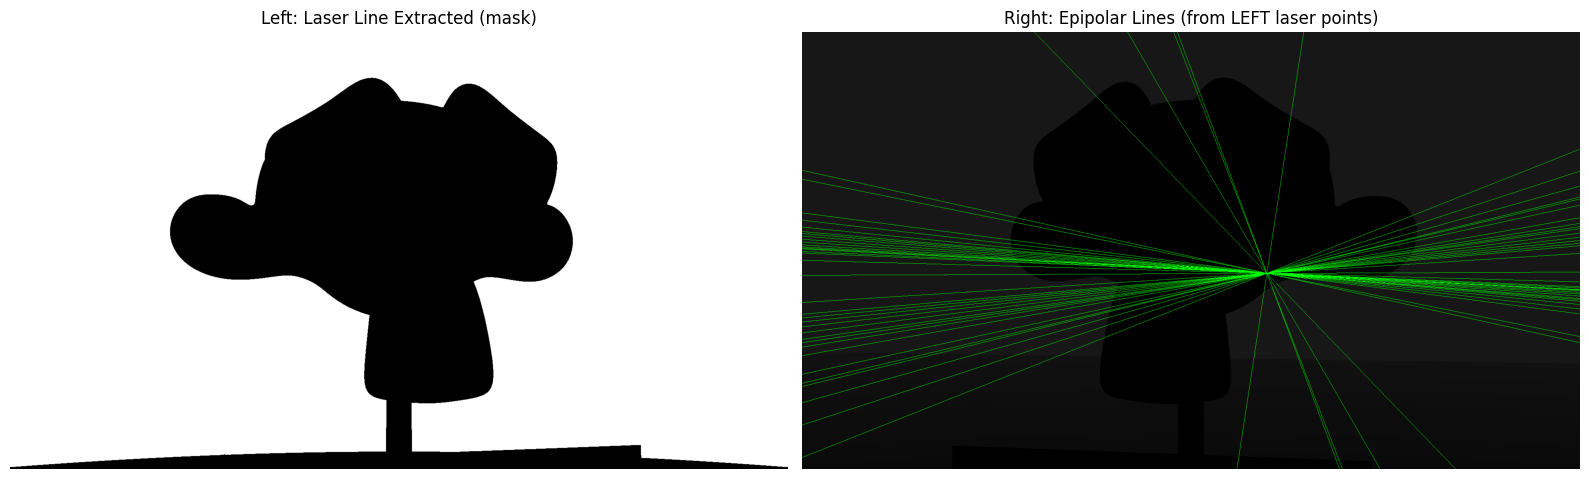

In [59]:
# ============================================================
# VISU "comme ton ami" : LEFT masque laser + RIGHT lignes épipolaires
# ============================================================

def get_epilines_in_right(F, ptsL):
    """
    Calcule les lignes épipolaires dans RIGHT pour des points LEFT.
    Retour: linesR (N,3) avec ax + by + c = 0
    """
    if len(ptsL) == 0:
        return np.empty((0,3), dtype=np.float64)
    linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
    return linesR.reshape(-1,3)

def draw_epilines(img_rgb, lines, color=(0,255,0), thickness=1):
    """
    Dessine des lignes épipolaires sur une image RGB.
    lines: (N,3) ax+by+c=0
    """
    h, w = img_rgb.shape[:2]
    out = img_rgb.copy()

    for a, b, c in lines:
        # éviter division par 0
        if abs(b) < 1e-12:
            continue

        # deux points sur les bords x=0 et x=w-1
        y0 = int(round((-c - a*0) / b))
        y1 = int(round((-c - a*(w-1)) / b))

        # dessiner même si ça sort un peu (OpenCV clip)
        cv2.line(out, (0, y0), (w-1, y1), color, thickness)

    return out

def overlay_points(img_rgb, pts, color=(255,0,0), r=2):
    """
    Ajoute des points (N,2) sur image RGB.
    """
    out = img_rgb.copy()
    for x, y in pts:
        cv2.circle(out, (int(round(x)), int(round(y))), r, color, -1)
    return out

# ----------- Exemple sur un scan (DEBUG_IDX) ---------------
imgL = cv2.imread(str(left_paths[DEBUG_IDX]))
imgR = cv2.imread(str(right_paths[DEBUG_IDX]))
imgR_rgb = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

maskL, nameL, _ = best_laser_mask(imgL)
ptsL = extract_laser_points(maskL, sample_step=SAMPLE_STEP)

print(f"[EPI DEBUG] LEFT mask type = {nameL} | extracted pts = {len(ptsL)}")

# Sous-échantillonnage pour éviter un mur de lignes (comme ton ami : 1 sur 100)
sample_rate = 10  # mets 50 ou 100 si tu veux moins de lignes
ptsL_sampled = ptsL[::sample_rate] if len(ptsL) else ptsL
print(f"[EPI DEBUG] sampled pts = {len(ptsL_sampled)} (1/{sample_rate})")

# Lignes épipolaires dans RIGHT
linesR = get_epilines_in_right(F, ptsL_sampled)
imgR_with_lines = draw_epilines(imgR_rgb, linesR, color=(0,255,0), thickness=1)

# (Option) superposer aussi les points laser RIGHT si tu veux
# maskR, _, _ = best_laser_mask(imgR)
# ptsR = extract_laser_points(maskR, sample_step=SAMPLE_STEP)
# imgR_with_lines = overlay_points(imgR_with_lines, ptsR, color=(255,0,0), r=1)

# Affichage "comme ton ami"
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title("Left: Laser Line Extracted (mask)")
plt.imshow(maskL, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Right: Epipolar Lines (from LEFT laser points)")
plt.imshow(imgR_with_lines)
plt.axis("off")

plt.tight_layout()
plt.show()


Nb scans Left : 26
Nb scans Right: 26
[DEBUG 0] ptsL=0 ptsR=0 matched=0 X=0


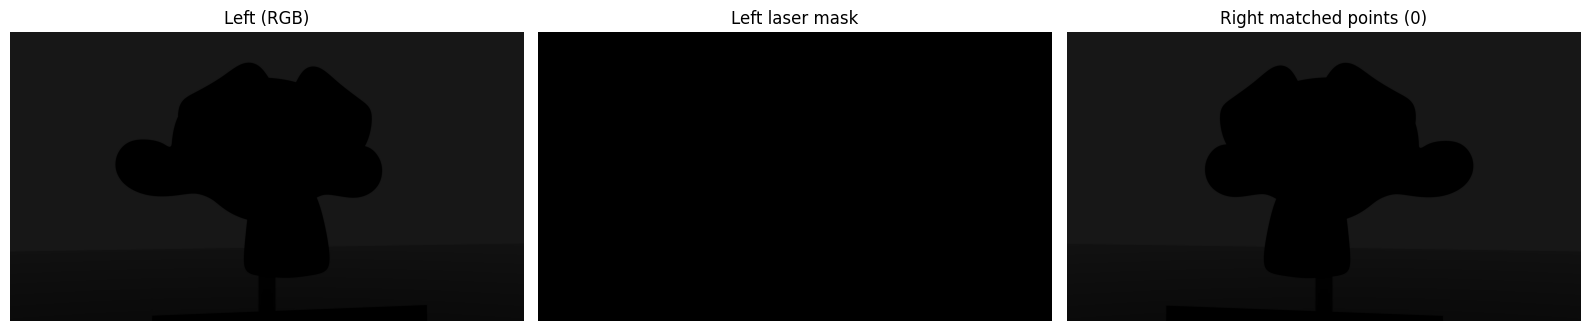

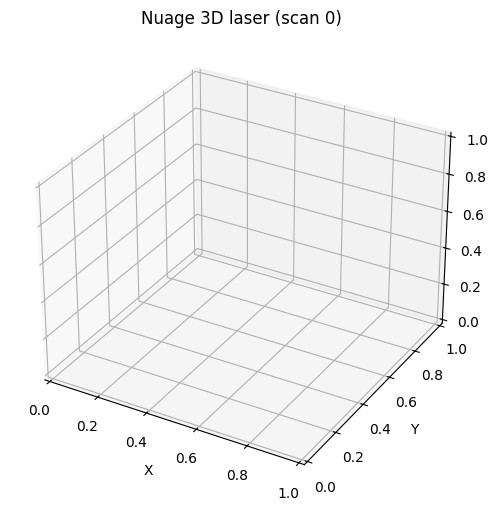

Nuage final (tous scans): (25, 3)


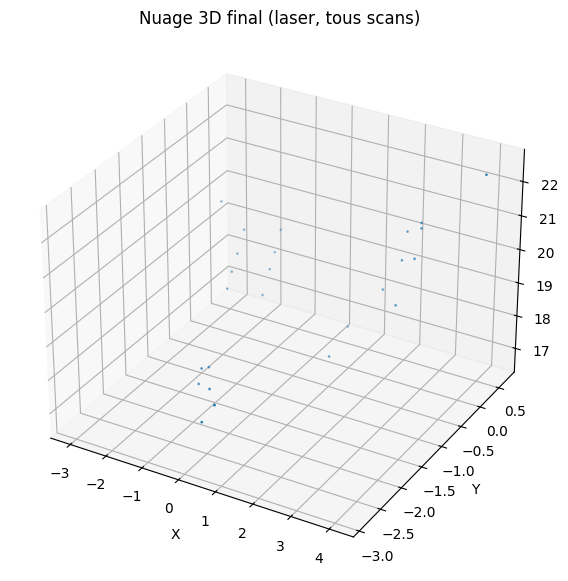

In [106]:
# ============================================================
# ÉTAPE LASER — Masque 2D -> points -> matching épipolaire -> triangulation 3D
# ============================================================

from pathlib import Path
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

SCAN_LEFT_DIR  = Path("data/scanLeft")
SCAN_RIGHT_DIR = Path("data/scanRight")

left_paths  = sorted(Path(p) for p in glob.glob(str(SCAN_LEFT_DIR / "*.png")))
right_paths = sorted(Path(p) for p in glob.glob(str(SCAN_RIGHT_DIR / "*.png")))

print("Nb scans Left :", len(left_paths))
print("Nb scans Right:", len(right_paths))
assert len(left_paths) == len(right_paths) and len(left_paths) > 0

# -----------------------------
# A) Masque laser (simple, canal rouge)
# -----------------------------
def laser_mask_red_channel(img_bgr, thresh=127):
    red = img_bgr[:,:,2]  # BGR -> canal R
    _, mask = cv2.threshold(red, thresh, 255, cv2.THRESH_BINARY)
    # nettoyage léger
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return mask  # (H,W) uint8

# -----------------------------
# B) Extraire une ligne laser : 1 point par colonne
# -----------------------------
def extract_laser_points(mask, step=5, min_pixels=200):
    ys, xs = np.where(mask > 0)
    if len(xs) < min_pixels:
        return np.empty((0,2), dtype=np.float64)

    pts = []
    for x in np.unique(xs):
        y_vals = ys[xs == x]
        pts.append((float(x), float(np.mean(y_vals))))

    pts = np.array(pts, dtype=np.float64)
    if step > 1 and len(pts) > step:
        pts = pts[::step]
    return pts  # (N,2)

# -----------------------------
# C) Matching par épipolaire : choisir le point RIGHT le plus proche de la ligne
# -----------------------------
def match_epipolar(F, ptsL, ptsR, max_dist_px=3.0):
    if len(ptsL) == 0 or len(ptsR) == 0:
        return np.empty((0,2)), np.empty((0,2))

    linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F).reshape(-1,3)

    XR, YR = ptsR[:,0], ptsR[:,1]
    outL, outR = [], []

    for (xL,yL), (a,b,c) in zip(ptsL, linesR):
        denom = np.sqrt(a*a + b*b) + 1e-12
        d = np.abs(a*XR + b*YR + c) / denom
        j = int(np.argmin(d))
        if d[j] <= max_dist_px:
            outL.append([xL, yL])
            outR.append([ptsR[j,0], ptsR[j,1]])
    return np.array(outL, dtype=np.float64), np.array(outR, dtype=np.float64)

# -----------------------------
# D) Triangulation
# -----------------------------
def triangulate(P1, P2, ptsL, ptsR):
    if len(ptsL) == 0:
        return np.empty((0,3), dtype=np.float64)
    X_h = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)  # (4,N)
    X = (X_h[:3,:] / (X_h[3,:] + 1e-12)).T
    return X

# -----------------------------
# E) Debug sur un scan
# -----------------------------
DEBUG_IDX = 0
STEP = 5
MAX_DIST = 3.0
THRESH = 127

imgL = cv2.imread(str(left_paths[DEBUG_IDX]))
imgR = cv2.imread(str(right_paths[DEBUG_IDX]))

mL = laser_mask_red_channel(imgL, thresh=THRESH)
mR = laser_mask_red_channel(imgR, thresh=THRESH)

ptsL = extract_laser_points(mL, step=STEP)
ptsR = extract_laser_points(mR, step=STEP)

ptsL_m, ptsR_m = match_epipolar(F, ptsL, ptsR, max_dist_px=MAX_DIST)
X = triangulate(P1, P2, ptsL_m, ptsR_m)
X = X[np.isfinite(X).all(axis=1)]
X = X[X[:,2] > 0]

print(f"[DEBUG {DEBUG_IDX}] ptsL={len(ptsL)} ptsR={len(ptsR)} matched={len(ptsL_m)} X={len(X)}")

# Affichage : masque L + image R avec matched points
imgL_rgb = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgR_rgb = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

tmpR = imgR_rgb.copy()
for (x,y) in ptsR_m:
    cv2.circle(tmpR, (int(x), int(y)), 2, (255,0,0), -1)

plt.figure(figsize=(16,6))
plt.subplot(1,3,1); plt.title("Left (RGB)"); plt.imshow(imgL_rgb); plt.axis("off")
plt.subplot(1,3,2); plt.title("Left laser mask"); plt.imshow(mL, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Right matched points ({len(ptsR_m)})"); plt.imshow(tmpR); plt.axis("off")
plt.tight_layout(); plt.show()

# Nuage 3D (debug scan)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
if len(X) > 0:
    ax.scatter(X[:,0], X[:,1], X[:,2], s=2)
ax.set_title(f"Nuage 3D laser (scan {DEBUG_IDX})")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

# -----------------------------
# F) Nuage final : accumuler tous les scans
# -----------------------------
X_all = []
for pL, pR in zip(left_paths, right_paths):
    imL = cv2.imread(str(pL))
    imR = cv2.imread(str(pR))
    mL = laser_mask_red_channel(imL, thresh=THRESH)
    mR = laser_mask_red_channel(imR, thresh=THRESH)

    qL = extract_laser_points(mL, step=STEP)
    qR = extract_laser_points(mR, step=STEP)

    qL_m, qR_m = match_epipolar(F, qL, qR, max_dist_px=MAX_DIST)
    X_i = triangulate(P1, P2, qL_m, qR_m)

    if len(X_i) == 0:
        continue
    X_i = X_i[np.isfinite(X_i).all(axis=1)]
    X_i = X_i[X_i[:,2] > 0]
    if len(X_i) > 0:
        X_all.append(X_i)

X_all = np.vstack(X_all) if len(X_all) else np.empty((0,3))
print("Nuage final (tous scans):", X_all.shape)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")
if len(X_all) > 0:
    ax.scatter(X_all[:,0], X_all[:,1], X_all[:,2], s=1)
ax.set_title("Nuage 3D final (laser, tous scans)")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()
